# Приоритизация гипотез и анализ результатов A/B теста для интернет-магазина

По результатам A/B теста по требуется сделать вывод можно ли выводить
изменение на всех пользователей и приоритезировать гипотезы с помощью методологий RICE и ICE.

### Описание данных

Файл hypothesis.csv  
- Hypothesis — краткое описание гипотезы;  
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл orders.csv
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл visitors.csv
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

### План проекта:  
[Часть 1. Приоритизация гипотез](#step1)  
- [Загрузка данных.](#step1.0)
- [Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.](#step1.1)
- [Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета](#step1.2)
- [Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло](#step1.3)  

[Часть 2. Анализ A/B-теста](#step2)  
- [Загрузка данных.](#step2.0)
- [Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.](#step2.1)
- [Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.](#step2.2)
- [Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.](#step2.3)
- [Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.](#step2.4)
- [Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.](#step2.5)
- [Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.](#step2.6)
- [Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.](#step2.7)
- [Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.](#step2.8)
- [Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.](#step2.9)
- [Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.](#step2.10)
- [Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.](#step2.11)
- [Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.](#step2.12)
- [Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.](#step2.13)
- [Примите решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.](#step2.14)


Напишем функцию для пути файла, чтобы файл открывался и на локальном компьютере, и в практикуме

In [106]:
import os
def try_path(path):
    if os.path.exists(path):
        return path
    else:
        return "." + path

Подключим библиотеки, которые нам потребуются в дальнейшем

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from scipy import stats as st

Включим опцию, которая позволит видеть весь текст, а не только его начало в столбцах, содержащих текст

In [108]:
pd.set_option('display.max_colwidth', 500)

### <a id="step1"> Часть 1. Приоритизация гипотез</a>

### - <a id="step1.0"> Загрузка данных.</a>

Считаем данные об оценке гипотез из файла. Посмотрим первые 5 строк

In [109]:
hypothesis = pd.read_csv(try_path('/datasets/hypothesis.csv'))
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


Посмотрим описательные статистики по таблице

In [110]:
hypothesis.describe()

,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


Видно, что в таблице 9 записей. Хранящиеся значения совпадают с описанием, в каждом из полей хранится оценка от 1 до 10

Проверим все ли в порядке с типами данных

In [111]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


С типами данных все в порядке, можем приступить к дальнейшему анализу

### <a id="step1.1">- Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.</a>

По методологии ICE приоритет считается по следующей формуле: ICE = impact*confidence / effort. Добавим в таблицу с гипотезами их приоритет по ICE и отсортируем по убыванию приоритета

In [112]:
hypothesis['ICE'] = round(hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts'],2)
hypothesis.sort_values(by = 'ICE', ascending = False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


По методологии ICE: 
- Гипотеза "Запустить акцию, дающую скидку на товар в день рождения" получилась самой приоритетной. Мы знаем, что это изменение сильно повлияет на пользователей,  сложность тестирования гипотезы займет среднее значение, уверены в своих оценках влияния на пользователей и затрат.  
- Гипотеза "Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей" - наименее приоритетная. Мы оценили ее эффект и трудозатраты на ее проверку как минимальные, но при этом совсем не уверены в своих оценках

### <a id="step1.2">- Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.</a>

По методологии RICE приоритет считается по следующей формуле: RICE = reach * impact*confidence / effort. Добавим в таблицу с гипотезами их приоритет по RICE и отсортируем по убыванию приоритета

In [113]:
hypothesis['RICE'] = round(hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts'],2)
hypothesis.sort_values(by = 'RICE', ascending = False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


По методологии RICE:
- Гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" самая приоритетная. У нее весьма высокие значения влияния на пользователей и уверенности в тех оценках, которые мы дали. Затраты на нее принимают среднее значение. Мы считаем, что это охватит большое количество пользователей
- Гипотеза "Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей" - наименее приоритетная. Мы оценили ее эффект и трудозатраты на нее как минимальные, но при этом совсем не уверены в своих оценках. Охват у нее тоже совем небольшой

### <a id="step1.3">- Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.</a>

- Гипотеза "Запустить акцию, дающую скидку на товар в день рождения" по методологии ICE занимает первое место, по RICE - лишь пятое. Это связано с тем, что в RICE мы учитываем охват пользователей, а у этой гипотезы он совем небольшой, т.к. она влияет только на пользователей, у которых день рождения. В ICE она же занимает высокую позицию, т.к. сильно влияет на пользователей, у которых день рождения, и не требует больших затрат
- Гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" по методологии ICE занимает третью позицию, по RICE - первую. Это связано с тем, что охват этой гипотезы - все пользователи. Все пользователи, которые зайдут на наш сайт увидят форму подписки. При этом мы считаем, что степень влияния рассылки на увеличение выручки чуть выше среднего
- Гипотеза "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" занимает пятую позицию по ICE, вторую - по RICE. У нее высокий охват - все пользователи, зашедшие в интернет-магазин, которые уже являются нашими клиентами. По ICE она заняла невысокую позицию, т.к. мы считаем, что это изменение не сильно повлияет на увеличение прибыли
- Гипотеза "Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар" занимает предпоследнюю позицию по ICE, по RICE - на три позиции выше. Это связано с тем, что охват у этой гипотезы большой, все посетители интернет- магазина, которые ищут товары через дерево категорий. При этом мы считаем, что степень влияния изменения структуры категорий на увеличение выручки очень маленькое

### <a id="step2"> Часть 2. Анализ A/B-теста</a>

### - <a id="step2.0"> Загрузка данных.</a>

Считаем данные о заказах из файла. Посмотрим первые пять строк

In [114]:
orders = pd.read_csv(try_path('/datasets/orders.csv'))
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Считаем данные о визитах из файла. Посмотрим первые пять строк

In [115]:
visits = pd.read_csv(try_path('/datasets/visitors.csv'))
visits.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Посмотрим информацию по таблицам

In [116]:
print(orders.info())
print(visits.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None


Пропущенных значений нет. Даты записаны как строки и в той, и в другой таблице. Приведем даты к корректному типу

In [117]:
orders['date'] = pd.to_datetime(orders['date'])
visits['date'] = pd.to_datetime(visits['date'])

print(orders['date'].dtypes)
print(visits['date'].dtypes)

datetime64[ns]
datetime64[ns]


Посмотрим описательные статистики по таблицам

In [118]:
print(orders.describe())
print(visits.describe())

       transactionId     visitorId       revenue
count   1.197000e+03  1.197000e+03  1.197000e+03
mean    2.155621e+09  2.165960e+09  8.348006e+03
std     1.229085e+09  1.236014e+09  3.919113e+04
min     1.062393e+06  5.114589e+06  5.000000e+01
25%     1.166776e+09  1.111826e+09  1.220000e+03
50%     2.145194e+09  2.217985e+09  2.978000e+03
75%     3.237740e+09  3.177606e+09  8.290000e+03
max     4.293856e+09  4.283872e+09  1.294500e+06
         visitors
count   62.000000
mean   607.290323
std    114.400560
min    361.000000
25%    534.000000
50%    624.500000
75%    710.500000
max    770.000000


Странных значений нет, если обнаружим выбросы, разберемся с ними по ходу проекта

Посмотрим за какой период у нас хранятся данные в наших таблицах

In [119]:
print(visits['date'].min())
print(visits['date'].max())
print()
print(orders['date'].min())
print(orders['date'].max())

2019-08-01 00:00:00
2019-08-31 00:00:00

2019-08-01 00:00:00
2019-08-31 00:00:00


Данные собраны за август 2019 года

Переименуем названия столбцов в таблице orders на более удобные

In [120]:
orders.columns = ['transaction_id', 'visitor_id','date','revenue', 'group']
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Проверим нет ли дублей в данных

In [121]:
print(orders.duplicated().sum())
print(visits.duplicated().sum())

0
0


Дублей в данных нет

### <a id="step2.1">- Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.</a>

Посчитаем суммарную выручку, количество транзакций за каждый день для каждой из групп

In [122]:
orders_by_date_and_group = orders.groupby(['group','date'], as_index = False).agg({'revenue':'sum','transaction_id':'count'})
orders_by_date_and_group.columns = ['group','date','revenue','transactions']
orders_by_date_and_group.head()

,group,date,revenue,transactions
0,A,2019-08-01,148579,24
1,A,2019-08-02,93822,20
2,A,2019-08-03,112473,24
3,A,2019-08-04,70825,16
4,A,2019-08-05,124218,25


Посчитаем накопленнную выручку и накопленное количество транзакций за каждый день для каждой из групп 

In [123]:
# функция возвращает для строки датафрейма orders_by_date_and_group /
# группу , дату наблюдений, накопленное количество транзакций на этот день и накопленную выручку
def count_cumulative_values(row):
    group = row['group']
    date = row['date']
    filtered = orders_by_date_and_group.query('group == @group and date <= @date') # находим все заказы определенной группы до определенной даты
    revenue = filtered['revenue'].sum() # находим суммарную выручку по группе до определенной даты
    transactions_qty = filtered['transactions'].sum()# находим суммарное количество транзакций до определенной даты
    return (pd.Series([group, date, revenue, transactions_qty]))

cumulative = orders_by_date_and_group.apply(count_cumulative_values, axis = 1)
cumulative.columns = ['group','date','revenue','transactions_qty']
cumulative.head()

,group,date,revenue,transactions_qty
0,A,2019-08-01,148579,24
1,A,2019-08-02,242401,44
2,A,2019-08-03,354874,68
3,A,2019-08-04,425699,84
4,A,2019-08-05,549917,109


Напишем функцию, которая будет строить кумулятивные графики по группам по датафрейму cumulative. На вход функция принимает колонку, по которой надо построить график, подпись для оси y, заголовок для графика

In [124]:
def show_cumulative_graphics_for_group(column, ylabel, title): 
    cumulative_A = cumulative.loc[cumulative["group"] == 'A'] 
    cumulative_B = cumulative.loc[cumulative["group"] == 'B']

    plt.figure(figsize=(12,6)) 

    #  построим график для группы А
    plt.plot(cumulative_A['date'], cumulative_A[column], label='A');

    # построим график для группы B
    plt.plot(cumulative_B['date'], cumulative_B[column], label='B');

    plt.legend();
    plt.xlabel('Дата наблюдений');
    plt.ylabel(ylabel);
    plt.title(title);

Построим график кумулятивной выручки по группам с помощью нашей функции

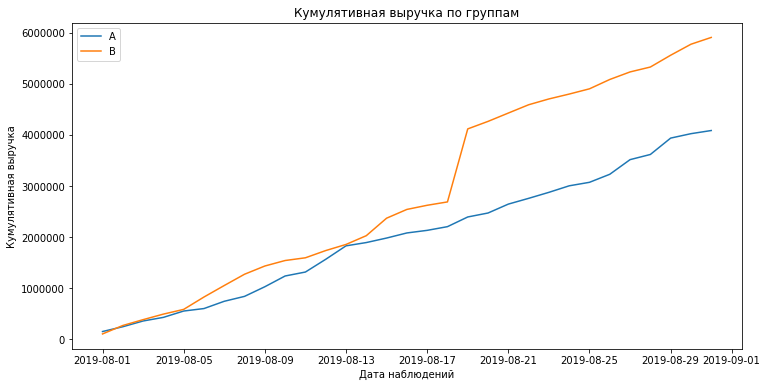

In [125]:
show_cumulative_graphics_for_group('revenue','Кумулятивная выручка','Кумулятивная выручка по группам')

### Вывод

Выручка равномерно увеличивается и в той, и в другой группе. В начале месяца кумулятивная выручка группы B почти совпадает с группой A. До 17.08 кумулятивная выручка группы A чуть ниже группы B. В райне 20.08 есть резкий скачок выручки группы B, возможно, это связано или с очень большой покупкой, или с большим количеством заказов в этот день. Рассмотрим данный выброс в следующих шагах. Скорее всего выручка группы B без выбросов выше группы A, но не так сильно

### <a id="step2.2">- Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.</a>

Посчитаем кумулятивный средний чек за каждый день для каждой из групп

In [126]:
cumulative['avg_check'] = cumulative['revenue'] / cumulative['transactions_qty']
cumulative.head()

,group,date,revenue,transactions_qty,avg_check
0,A,2019-08-01,148579,24,6190.791667
1,A,2019-08-02,242401,44,5509.113636
2,A,2019-08-03,354874,68,5218.735294
3,A,2019-08-04,425699,84,5067.845238
4,A,2019-08-05,549917,109,5045.110092


Построим график кумулятивного среднего чека по группам с помощью функции, которую мы написали на предыдущем шаге

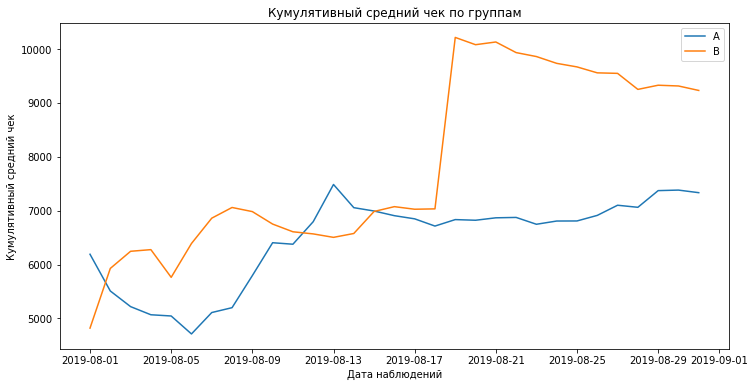

In [127]:
show_cumulative_graphics_for_group('avg_check','Кумулятивный средний чек','Кумулятивный средний чек по группам')

### Вывод

Средний чек группы A стабильно ниже группы B кроме небольшого всплеска в районе 13.08. В районе 20.08 виден резкий всплеск среднего чека в группе B. Его же мы видели на предыдущем шаге по выручке. получается, что в этот день был какой-то дорогой заказ. Без этого всплеска средний чек группы B возможно даже ниже группы A

### <a id="step2.3">- Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.</a>

Напишем функцию, которая будет по датафрейму cumulative выводить относительное изменение кумулятивного параметра группы B к группе A по дням и строить график для этого изменения. На вход функция принимает колонку, по которой нужно сделать расчет 

In [128]:
def show_relational_cumulative_change(col):
    cumulative_A = cumulative.loc[cumulative["group"] == 'A'] 
    cumulative_B = cumulative.loc[cumulative["group"] == 'B']
    
    cumulative_A_B = cumulative_A[['date',col]].merge(cumulative_B[['date',col]], on = 'date', suffixes = ('_A','_B'))

    cumulative_A_B[col+'_change'] = cumulative_A_B[col+'_B'] / cumulative_A_B[col+'_A'] - 1 
    print(cumulative_A_B.head())
    
    plt.figure(figsize=(12,6)) 

    plt.plot(cumulative_A_B['date'], cumulative_A_B[col+'_change']);
    plt.axhline(y=0, color='black', linestyle='--');

Применим нашу функцию к среднему чеку

        date  avg_check_A  avg_check_B  avg_check_change
0 2019-08-01  6190.791667  4819.857143         -0.221447
1 2019-08-02  5509.113636  5927.733333          0.075987
2 2019-08-03  5218.735294  6245.836066          0.196810
3 2019-08-04  5067.845238  6276.500000          0.238495
4 2019-08-05  5045.110092  5762.326733          0.142161


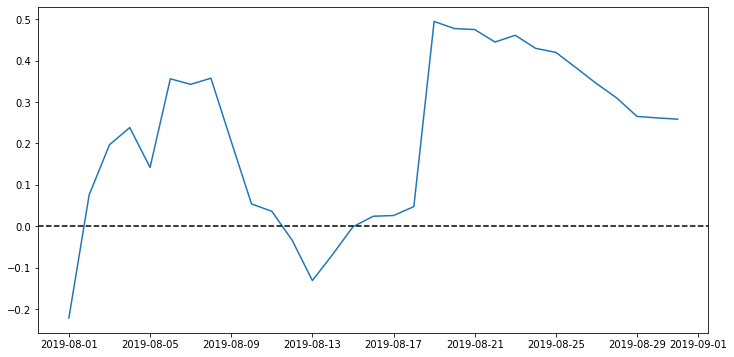

In [129]:
show_relational_cumulative_change('avg_check')

### Вывод

В нескольких датах есть резкие всплески среднего чека группы B относительно группы A. Это тоже скорее всего связано с выбросами, разберемся с ними далее. Средний чек группы B в основном выше среднего чека группы A

### <a id="step2.4">- Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.</a>

Напишем функцию, которая будет высчитывать накопленное количество визитов для каждой из строк датафрейма visits. Сохраним в датафрейме cumulative_visits с помощью этой функции накопленное количество визитов для каждой группы. для каждой из дат

In [130]:
# функция возвращает для строки датафрейма visits /
# группу , дату наблюдений, накопленное количество визитов на этот день 
def count_cumulative_visits(row):
    group = row['group']
    date = row['date']
    filtered = visits.query('group == @group and date <= @date') # находим все визиты определенной группы до определенной даты
    visits_qty = filtered['visitors'].sum() # находим суммарное количество визитов до определенной даты
    return (pd.Series([group, date, visits_qty]))

cumulative_visits = visits.apply(count_cumulative_visits, axis = 1)
cumulative_visits.columns = ['group','date','visits_qty']
cumulative_visits.head()

,group,date,visits_qty
0,A,2019-08-01,719
1,A,2019-08-02,1338
2,A,2019-08-03,1845
3,A,2019-08-04,2562
4,A,2019-08-05,3318


Присоединим информацию о кумулятивном количестве визитов к датафрейму с другими кумулятивными метриками, которые мы рассчитали раннее

In [131]:
cumulative = cumulative.merge(cumulative_visits, on = ['date','group'])
cumulative.head()

,group,date,revenue,transactions_qty,avg_check,visits_qty
0,A,2019-08-01,148579,24,6190.791667,719
1,A,2019-08-02,242401,44,5509.113636,1338
2,A,2019-08-03,354874,68,5218.735294,1845
3,A,2019-08-04,425699,84,5067.845238,2562
4,A,2019-08-05,549917,109,5045.110092,3318


Рассчитаем кумулятивную конверсию

In [132]:
cumulative['conversion'] = cumulative['transactions_qty'] / cumulative['visits_qty']
cumulative.head()

,group,date,revenue,transactions_qty,avg_check,visits_qty,conversion
0,A,2019-08-01,148579,24,6190.791667,719,0.033380
1,A,2019-08-02,242401,44,5509.113636,1338,0.032885
2,A,2019-08-03,354874,68,5218.735294,1845,0.036856
3,A,2019-08-04,425699,84,5067.845238,2562,0.032787
4,A,2019-08-05,549917,109,5045.110092,3318,0.032851


Построим график кумулятивной конверсии с помощью функции, которую мы написали раннее

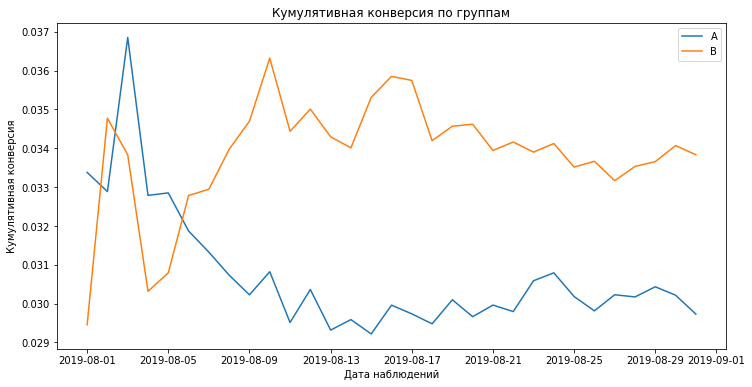

In [133]:
show_cumulative_graphics_for_group('conversion','Кумулятивная конверсия','Кумулятивная конверсия по группам')

### Вывод

До 05.08 у группы B конверсия была ниже. Конверсия группы A просела в районе 05.08 и осталась примерно на том же уровне с небольшими всплесками. Конверсия группв возросла и с небольшими колебаниями держится примерно на том же уровне

### <a id="step2.5">- Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.</a>

Посмотрим график с помощью функции, которую мы написали раннее show_relational_cumulative_change

        date  conversion_A  conversion_B  conversion_change
0 2019-08-01      0.033380      0.029453          -0.117637
1 2019-08-02      0.032885      0.034776           0.057503
2 2019-08-03      0.036856      0.033833          -0.082045
3 2019-08-04      0.032787      0.030315          -0.075398
4 2019-08-05      0.032851      0.030793          -0.062659


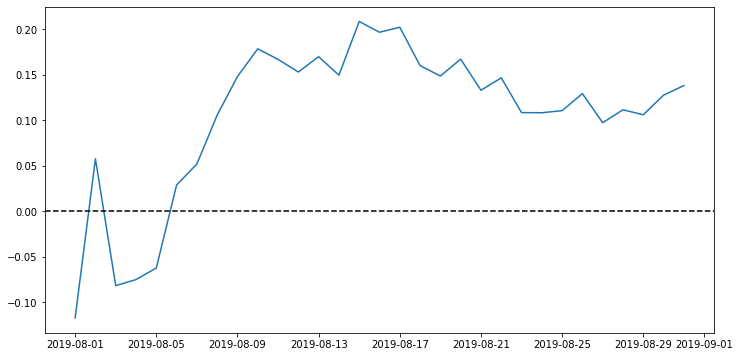

In [134]:
show_relational_cumulative_change('conversion')

### Вывод

В начале теста конверсия групппы B была в основном ниже группы B. Конверсия группы B начала расти после 07.08 относительно группы B и стабильно больше конверсии группы A. Похоже, что наше изменение и правда положительно влияет на конверсию

<a id="step2.6">- Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.</a>

Посчитаем количество заказов для каждого из пользователей

In [135]:
orders_qty = orders.groupby(['group','visitor_id']).agg({'transaction_id':'count'}).reset_index()
orders_qty.head()

,group,visitor_id,transaction_id
0,A,8300375,1
1,A,11685486,1
2,A,54447517,1
3,A,66685450,1
4,A,78758296,1


Построим точечный график количества заказов по пользователям

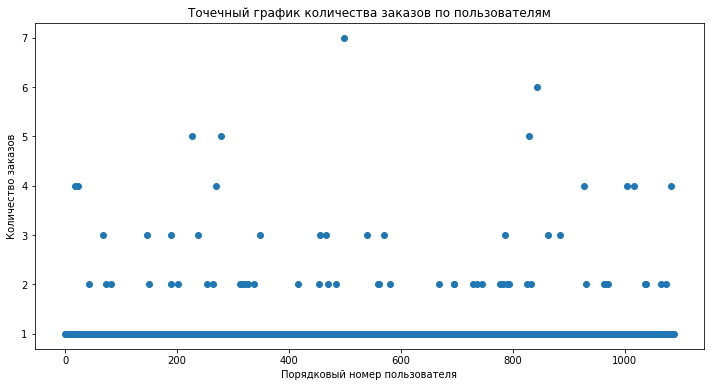

In [136]:
x_values = pd.Series(range(0,len(orders_qty['transaction_id']))) # пронумеруем всех пользователей.\
#На оси x вместо длинных id пользователей будем показывать его порядковый номер
plt.figure(figsize=(12,6));
plt.scatter(x_values, orders_qty['transaction_id'])
plt.xlabel('Порядковый номер пользователя');
plt.ylabel('Количество заказов');
plt.title('Точечный график количества заказов по пользователям');

### Вывод

Очень мало людей сделали 4 заказа и более

### <a id="step2.7">- Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.</a>

Посчитаем 95, 99 перцентили количества заказов на пользователей

In [137]:
print(np.percentile(orders_qty['transaction_id'],[95,99]))

[2. 4.]


### Вывод

Только 1% пользователей сделал более 4 заказов. Выберем 4 заказа в качестве границы для определения аномальных пользователей

### <a id="step2.8">- Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.</a>

Построим точечный график стоимостей заказов

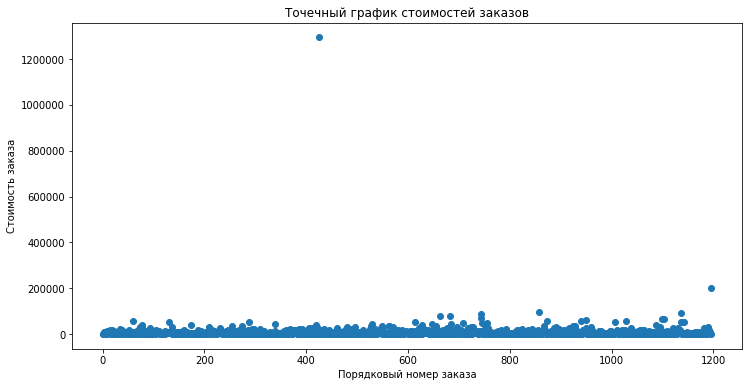

In [138]:
x_values = pd.Series(range(0,len(orders['revenue']))) # пронумеруем все заказы.\
#На оси x будем показывать порядковый номер заказа
plt.figure(figsize=(12,6));
plt.scatter(x_values, orders['revenue'])
plt.xlabel('Порядковый номер заказа');
plt.ylabel('Стоимость заказа');
plt.title('Точечный график стоимостей заказов');

### Вывод

Есть всего два заказа стоимостью более 200 000

### <a id="step2.9">- Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.</a>

In [139]:
print(np.percentile(orders['revenue'],[95,99]))

[28000.  58233.2]


Не более 5% заказов дороже 28000 и менее 1% дороже 58233.2. Выберем в качестве границы для определения аномальных заказов 58233.2

### <a id="step2.10">- Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.</a>

Для того чтобы посчитать статистическую значимость различий в конверсии нам сначала нужно посчитать для каждой из групп количество заказов с учетом нулевых заказов (когда пользователь зашел в сервис но заказ не сделал). 

Раннее мы считали количество заказов на пользователя в датафрейме orders_qty. Выделим из него количество заказов на пользователя для каждой из групп

In [140]:
orders_qty_per_user_A = orders_qty[orders_qty['group']=='A']
orders_qty_per_user_A.columns = ['group','visitor_id','transactions_qty']
orders_qty_per_user_B = orders_qty[orders_qty['group']=='B']
orders_qty_per_user_B.columns = ['group','visitor_id','transactions_qty']

display(orders_qty_per_user_A.head())
display(orders_qty_per_user_B.head())

,group,visitor_id,transactions_qty
0,A,8300375,1
1,A,11685486,1
2,A,54447517,1
3,A,66685450,1
4,A,78758296,1


,group,visitor_id,transactions_qty
503,B,5114589,1
504,B,6958315,1
505,B,8300375,1
506,B,39475350,1
507,B,47206413,1


Создадим датафреймы с визитами групп A и B

In [141]:
visits_A = visits[visits['group'] == "A"]
visits_B = visits[visits['group'] == "B"]

display(visits_A.head())
display(visits_B.head())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


,date,group,visitors
31,2019-08-01,B,713
32,2019-08-02,B,581
33,2019-08-03,B,509
34,2019-08-04,B,770
35,2019-08-05,B,707


Создадим series для каждой из групп, в котором запишем столько 0 сколько было визитов без заказов

In [142]:
zero_orders_A = pd.Series(0, index=np.arange(visits_A['visitors'].sum() - orders_qty_per_user_A['transactions_qty'].sum()), name='orders')
zero_orders_B = pd.Series(0, index=np.arange(visits_B['visitors'].sum() - orders_qty_per_user_B['transactions_qty'].sum()), name='orders')

display(zero_orders_A.head())
display(zero_orders_B.head())

0    0
1    0
2    0
3    0
4    0
Name: orders, dtype: int64

0    0
1    0
2    0
3    0
4    0
Name: orders, dtype: int64

Склеим записи с ненулевыми заказами и нулевыми заказами для каждой из групп

In [143]:
sampleA = pd.concat([orders_qty_per_user_A['transactions_qty'],zero_orders_A], axis = 0)
sampleB = pd.concat([orders_qty_per_user_B['transactions_qty'],zero_orders_A], axis = 0)

display(sampleA.head())
display(sampleB.head())

0    1
1    1
2    1
3    1
4    1
dtype: int64

503    1
504    1
505    1
506    1
507    1
dtype: int64

Применим к нашим выборкам тест Манна-Уитни. Зададим критический уровень статистической значимости в 5%
Среднее выборки по количеству заказов на пользователя и будет как раз являться конверсией  

Выдвинем гипотезы:  
H0: конверсия группы А по неочищенным данным равна конверсии группы B  
H1: конверсия группы А по неочищенным данным не равна конверсии группы B

In [144]:
alpha = .05

results = st.mannwhitneyu(sampleA, sampleB) 

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

p-значение:  0.006619726162499027
Отвергаем нулевую гипотезу: разница статистически значима


Получили, что конверсия группы B не равна конверсии группы A. Посчитаем относительный прирост конверсии группы B относительно группы A

In [145]:
print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

0.144


### Вывод

По неочищенным данным выходит, что конверсия группы B выше конверсии группы A. Относительный прирост конверсии группы B равен 14%

### <a id="step2.11">- Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения</a>

Применим тест Манна-Уитни. Зададим критический уровень статистической значимости в 5%  
В качестве выборок возьмем стоимость заказов для каждой из групп  
Среднее выборки по сумме заказов и будет как раз являться средним чеком  

Выдвинем гипотезы:  
H0: средний чек группы А по неочищенным данным равен среднему чеку группы B  
H1: средний чек группы А по неочищенным данным не равен среднему чеку группы B

In [146]:
alpha = .05

results = st.mannwhitneyu(orders[orders['group'] == "A"]['revenue'], orders[orders['group'] == "B"]['revenue'])

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

p-значение:  0.3646454927716229
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Не получилось отвергнуть гипотезу о том, что средний чек групп различен

Посчитаем относительное различие в среднем чеке между группами

In [147]:
print("{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.259


### Вывод

Не можем считать, что есть различия в среднем чеке между группами. При этом относительное различие в среднем чеке между группами очень большое 26%. Скорее всего это связано с большими покупками

### <a id="step2.12">- Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.</a>

В качестве аномальных пользователей мы решили считать пользователей с 4 и более заказами и с суммой покупок более чем 58233.2. Найдем id аномальных пользователей 

In [148]:
users_with_many_orders = pd.concat([orders_qty_per_user_A[orders_qty_per_user_A['transactions_qty'] >= 4]['visitor_id'],\
                                    orders_qty_per_user_B[orders_qty_per_user_B['transactions_qty'] >= 4]['visitor_id']], axis = 0)
users_with_expensive_orders = orders[orders['revenue'] > 58233.2]['visitor_id']
abnormal_users = pd.concat([users_with_many_orders, users_with_expensive_orders], axis = 0).drop_duplicates().sort_values()
print(abnormal_users.head(5))
print()
print(abnormal_users.shape[0])
print()
print(abnormal_users.shape[0]/(orders_qty_per_user_A.shape[0]+orders_qty_per_user_B.shape[0]))

1099    148427295
18      199603092
23      237748145
949     887908475
744     888512513
Name: visitor_id, dtype: int64

20

0.018365472910927456


Получилось 20 аномальных пользователей, 1.8% всех пользователей, сделавших заказы

Создадим выборки количества заказов по пользователям без аномальных пользователей

In [149]:
sampleA_filtered = pd.concat([orders_qty_per_user_A[np.logical_not(orders_qty_per_user_A['visitor_id'].isin(abnormal_users))]\
                             ['transactions_qty'], zero_orders_A],axis=0)

sampleB_filtered = pd.concat([orders_qty_per_user_B[np.logical_not(orders_qty_per_user_B['visitor_id'].isin(abnormal_users))]\
                             ['transactions_qty'], zero_orders_B],axis=0)
                               
display(sampleA_filtered.head())
display(sampleB_filtered.head())
                               

0    1
1    1
2    1
3    1
4    1
dtype: int64

503    1
504    1
505    1
506    1
507    1
dtype: int64

Применим к нашим выборкам тест Манна-Уитни. Зададим критический уровень статистической значимости в 5%
Среднее выборки по количеству заказов на пользователя и будет как раз являться конверсией  

Выдвинем гипотезы:  
H0: конверсия группы А по очищенным данным равна конверсии группы B  
H1: конверсия группы А по очищенным данным не равна конверсии группы B

In [150]:
alpha = .05

results = st.mannwhitneyu(sampleA_filtered, sampleB_filtered) 

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

p-значение:  0.006959430140151243
Отвергаем нулевую гипотезу: разница статистически значима


In [151]:
print("{0:.3f}".format(sampleB_filtered.mean()/sampleA_filtered.mean()-1))

0.151


### Вывод

По очищенным данным выходит, что конверсия группы B выше конверсии группы A. Относительный прирост конверсии группы B равен 15%. На 1% выше чем по неочищенным данным

### <a id="step2.13">- Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.</a>

Очистим данные по заказам от аномальных пользователей

In [152]:
sampleA_check_filtered = orders[np.logical_and(orders['group']=='A',\
                                               np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue']
sampleB_check_filtered = orders[np.logical_and(orders['group']=='B',\
                                               np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue']

display(sampleA_check_filtered.head())
display(sampleB_check_filtered.head())

2       400
7      1044
8     13710
10     4008
12     7370
Name: revenue, dtype: int64

0    1650
1     730
3    9759
4    2308
5    2210
Name: revenue, dtype: int64

Применим тест Манна-Уитни. Зададим критический уровень статистической значимости в 5%  
В качестве выборок возьмем стоимость заказов для каждой из групп  
Среднее выборки по сумме заказов и будет как раз являться средним чеком  

Выдвинем гипотезы:  
H0: средний чек группы А по очищенным данным равен среднему чеку группы B  
H1: средний чек группы А по очищенным данным не равен среднему чеку группы B

In [153]:
alpha = .05

results = st.mannwhitneyu(sampleA_check_filtered, sampleB_check_filtered) 

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

p-значение:  0.47942353987323266
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Посчитаем относительное различие в среднем чеке между группами

In [154]:
print("{0:.3f}".format(sampleB_check_filtered.mean()/sampleA_check_filtered.mean()-1))

-0.014


### Вывод

По очищенным данным вывод о том, что средний чек различен сделать нельзя. Относительный прирост среднего чека для группы B стал отрицательным на данных без выбросов 1.4%

### <a id="step2.14">- Примите решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.</a>

Получили следующие данные:  

Средний чек
- По неочищенным данным по графику различия среднего чека можно сказать, что у группы B он в основном сильно выше чем у группы A. Но скорее всего это связано с всплеском в районе 20.08. И похоже, что без этого всплеска средний чек группы B может в конце быть даже ниже чем группы A  
- И по неочищенным данным, и по очищенным - нет статистически значимого различия между средними чеками групп A и B

Конверсия
- По неочищенным данным по графику различий конверсии можно сказать, что конверсия группы B начала расти после 07.08 относительно группы B и стабильно больше конверсии группы A
- И по неочищенным данным, и по очищенным -  есть статистически значимое различие между конверсиями группы A и B. Относительный прирост конверсии группы B по очищенным данным равен 15%.

На основе этих данных можем остановить тест и зафиксировать победу группы B, т.к. статистически значимых различий между средними чеками в группах нет, а значит средний чек, если и ухудшается то не сильно, а конверсия растет и ее относительный прирост равен 15%